In [1]:
%matplotlib inline

In [2]:
import gc
import pathlib
import sys

In [3]:
import joblib
import lightgbm as lgb
import pandas as pd

In [4]:
root_dir_path = pathlib.Path("..")
data_dir_path = root_dir_path / "data"
processed_dir_path = data_dir_path / "processed"
train_path = processed_dir_path / "train_filtered.parquet"
models_dir_path = root_dir_path / "models"
model_path = models_dir_path / "model.joblib"
src_dir_path = root_dir_path / "src"

In [5]:
sys.path.append(str(src_dir_path))

In [6]:
from constants import *

In [7]:
train = pd.read_parquet(train_path)

In [8]:
is_train = train["date"] < "2016-01-29"
is_valid = train["date"] >= "2016-01-29"

In [9]:
X = train.loc[is_train, features]
X_valid = train.loc[is_valid, features]
y = train.loc[is_train, "demand"]
y_valid = train.loc[is_valid, "demand"]

In [10]:
del train
del is_train
del is_valid

In [11]:
gc.collect()

80

In [12]:
X.shape

(43375450, 28)

In [13]:
X.isnull().sum()

store_id                               0
item_id                                0
dept_id                                0
cat_id                                 0
state_id                               0
event_name_1                           0
event_type_1                           0
event_name_2                           0
event_type_2                           0
snap_CA                                0
snap_TX                                0
snap_WI                                0
sell_price                             0
year                                   0
dayofyear                              0
weekofyear                             0
quarter                                0
month                                  0
day                                    0
weekday                                0
is_year_start                          0
is_year_end                            0
is_month_start                         0
is_month_end                           0
demand_shift_28 

In [14]:
X_valid.shape

(2652507, 28)

In [15]:
X_valid.isnull().sum()

store_id                           0
item_id                            0
dept_id                            0
cat_id                             0
state_id                           0
event_name_1                       0
event_type_1                       0
event_name_2                       0
event_type_2                       0
snap_CA                            0
snap_TX                            0
snap_WI                            0
sell_price                         0
year                               0
dayofyear                          0
weekofyear                         0
quarter                            0
month                              0
day                                0
weekday                            0
is_year_start                      0
is_year_end                        0
is_month_start                     0
is_month_end                       0
demand_shift_28                    0
sell_price_day_over_day           11
demand_shift_1_rolling_28_mean     0
d

In [16]:
model = lgb.LGBMRegressor(importance_type="gain", learning_rate=0.05, n_estimators=1_000, random_state=0)

In [17]:
%%time
model.fit(
    X,
    y,
    categorical_feature=categorical_features,
    early_stopping_rounds=100,
    eval_metric="rmse",
    eval_set=[(X, y), (X_valid, y_valid)],
)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cat_id', 'dept_id', 'event_name_1', 'event_name_2', 'event_type_1', 'event_type_2', 'item_id', 'state_id', 'store_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's rmse: 4.2097	training's l2: 17.7215	valid_1's rmse: 3.53973	valid_1's l2: 12.5297
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 4.0817	training's l2: 16.6603	valid_1's rmse: 3.43008	valid_1's l2: 11.7655
[3]	training's rmse: 3.96235	training's l2: 15.7002	valid_1's rmse: 3.32796	valid_1's l2: 11.0753
[4]	training's rmse: 3.85131	training's l2: 14.8326	valid_1's rmse: 3.2324	valid_1's l2: 10.4484
[5]	training's rmse: 3.74813	training's l2: 14.0485	valid_1's rmse: 3.14368	valid_1's l2: 9.88271
[6]	training's rmse: 3.65239	training's l2: 13.34	valid_1's rmse: 3.0609	valid_1's l2: 9.36909
[7]	training's rmse: 3.56375	training's l2: 12.7003	valid_1's rmse: 2.98451	valid_1's l2: 8.9073
[8]	training's rmse: 3.48148	training's l2: 12.1207	valid_1's rmse: 2.91342	valid_1's l2: 8.48804
[9]	training's rmse: 3.40541	training's l2: 11.5968	valid_1's rmse: 2.84726	valid_1's l2: 8.10687
[10]	training's rmse: 3.3348	training's l2: 11.1209	valid_1's r

[84]	training's rmse: 2.46948	training's l2: 6.09835	valid_1's rmse: 2.08231	valid_1's l2: 4.336
[85]	training's rmse: 2.46804	training's l2: 6.09123	valid_1's rmse: 2.08281	valid_1's l2: 4.33811
[86]	training's rmse: 2.46655	training's l2: 6.08387	valid_1's rmse: 2.08217	valid_1's l2: 4.33545
[87]	training's rmse: 2.46531	training's l2: 6.07773	valid_1's rmse: 2.08235	valid_1's l2: 4.33618
[88]	training's rmse: 2.46431	training's l2: 6.07284	valid_1's rmse: 2.08176	valid_1's l2: 4.33371
[89]	training's rmse: 2.46317	training's l2: 6.06721	valid_1's rmse: 2.08149	valid_1's l2: 4.33261
[90]	training's rmse: 2.46224	training's l2: 6.06264	valid_1's rmse: 2.08122	valid_1's l2: 4.33146
[91]	training's rmse: 2.46131	training's l2: 6.05804	valid_1's rmse: 2.08094	valid_1's l2: 4.33032
[92]	training's rmse: 2.4603	training's l2: 6.05308	valid_1's rmse: 2.08071	valid_1's l2: 4.32937
[93]	training's rmse: 2.45946	training's l2: 6.04896	valid_1's rmse: 2.08057	valid_1's l2: 4.32878
[94]	training

[167]	training's rmse: 2.40817	training's l2: 5.79926	valid_1's rmse: 2.07274	valid_1's l2: 4.29626
[168]	training's rmse: 2.40768	training's l2: 5.79694	valid_1's rmse: 2.07274	valid_1's l2: 4.29625
[169]	training's rmse: 2.40739	training's l2: 5.79551	valid_1's rmse: 2.07268	valid_1's l2: 4.29601
[170]	training's rmse: 2.40692	training's l2: 5.79325	valid_1's rmse: 2.07266	valid_1's l2: 4.29591
[171]	training's rmse: 2.4064	training's l2: 5.79076	valid_1's rmse: 2.07231	valid_1's l2: 4.29448
[172]	training's rmse: 2.40594	training's l2: 5.78854	valid_1's rmse: 2.07269	valid_1's l2: 4.29606
[173]	training's rmse: 2.40547	training's l2: 5.78627	valid_1's rmse: 2.07356	valid_1's l2: 4.29963
[174]	training's rmse: 2.40503	training's l2: 5.78417	valid_1's rmse: 2.07352	valid_1's l2: 4.29949
[175]	training's rmse: 2.4047	training's l2: 5.78259	valid_1's rmse: 2.0735	valid_1's l2: 4.29942
[176]	training's rmse: 2.40414	training's l2: 5.7799	valid_1's rmse: 2.07353	valid_1's l2: 4.29954
[177

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='gain', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

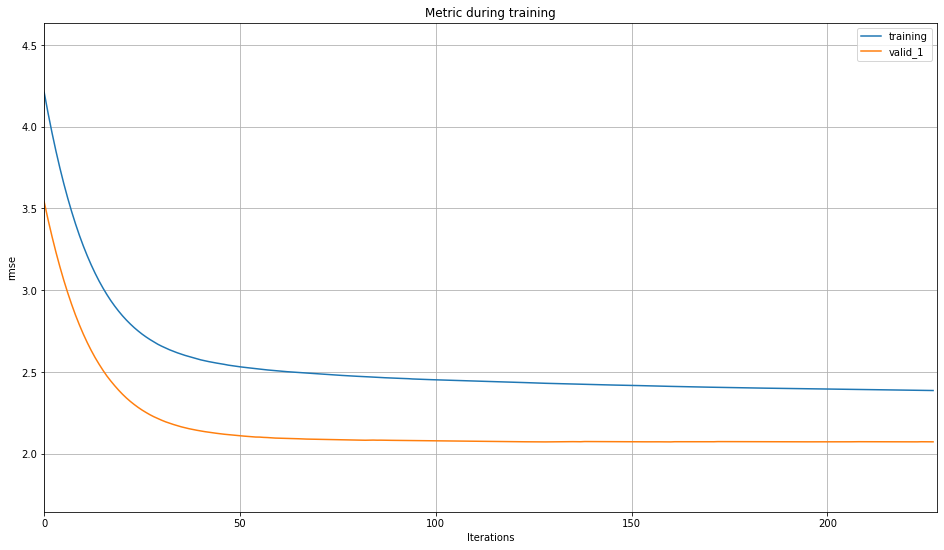

In [18]:
ax = lgb.plot_metric(model, metric="rmse", figsize=(16, 9))

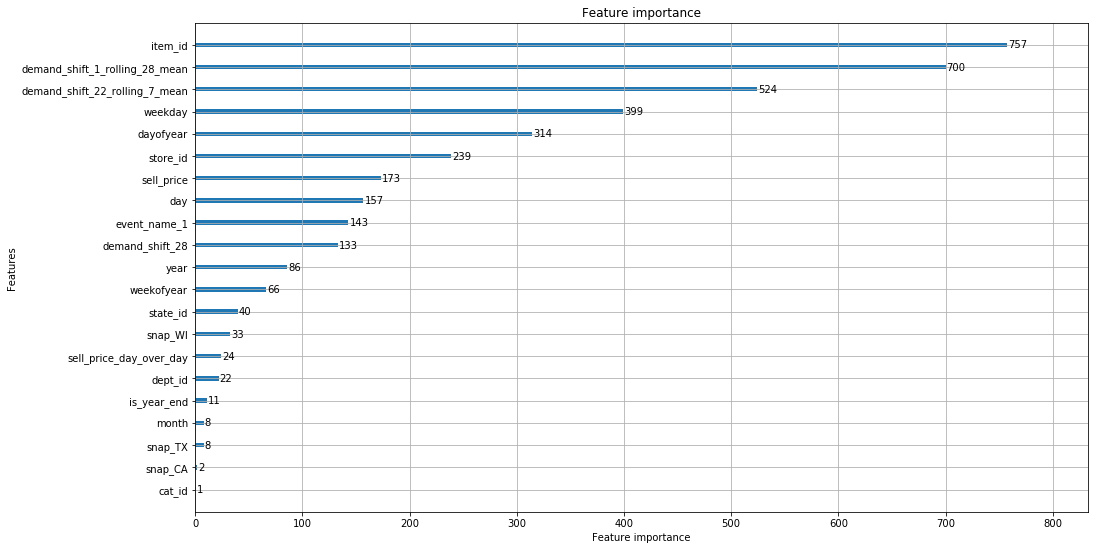

In [19]:
ax = lgb.plot_importance(model, figsize=(16, 9))

In [20]:
joblib.dump(model, model_path)

['../models/model.joblib']